In [17]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from ta.momentum import RSIIndicator
from ta.trend import IchimokuIndicator
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler


In [18]:
window_size = 30
batch_size = 128

In [35]:
stock_symbol = 'AAPL'
data = pd.read_csv(f'{stock_symbol}_historical_data.csv')
x = data[['High', 'Low', 'Close', 'Adj Close','Volume']]
rsi = RSIIndicator(close=x["Close"])
ichi = IchimokuIndicator(high=x["High"],low=x["Low"])
x['rsi'] = rsi.rsi()
x['ichi_b'] = ichi.ichimoku_b()
x['ichi_base'] = ichi.ichimoku_base_line()
'''
x['SMA_7'] = x['Close'].rolling(window=7).mean()
x['SMA_21'] = x['Close'].rolling(window=21).mean()
x['EMA_7'] = x['Close'].ewm(span=7, adjust=False).mean()
x['EMA_21'] = x['Close'].ewm(span=21, adjust=False).mean()
x['Momentum'] = x['Close'].diff(7)
mid = x['Close'].rolling(window=20).mean()
x['Upper_Band'] = mid + 2 * x['Close'].rolling(window=20).std()
x['Lower_Band'] = mid - 2 * x['Close'].rolling(window=20).std()
'''
x = x.dropna()
x = x.fillna(0)
x = x.values
X_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
t = np.concatenate((x[:,:2],x[:,3:]),axis=1)
m = np.reshape(x[:,2],(-1,1))
X_scaler.fit(t)
y_scaler.fit(m)
'''
scaler = MinMaxScaler()
x = scaler.fit_transform(x)
'''
'''
rolling_mean = x.rolling(window=5, min_periods=1).mean()
rolling_std = x.rolling(window=5, min_periods=1).std()
# Normalize the data
x = (x - rolling_mean) / rolling_std
'''
# Handle any NaN values that may have resulted from the rolling operation

print(x.shape)

(6129, 8)
(6129, 8)


/var/folders/zv/rfxft3f92_l_ch40bgx1qqpw0000gn/T/ipykernel_6777/3216738497.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['rsi'] = rsi.rsi()


Feature 0: 27115584.832270
Feature 1: 28995559.820509
Feature 2: 12224233.267722
Feature 3: 1093.545251
Feature 4: 0.956695
Feature 5: 663282.064732
Feature 6: 1234265.675710


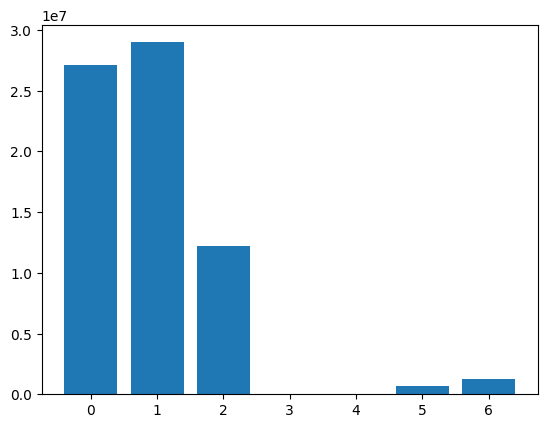

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

def select_features(X_train, y_train, X_test):
 # configure to select all features
 fs = SelectKBest(score_func=f_regression, k='all')
 # learn relationship from training data
 fs.fit(X_train, y_train)
 # transform train input data
 X_train_fs = fs.transform(X_train)
 # transform test input data
 X_test_fs = fs.transform(X_test)
 return X_train_fs, X_test_fs, fs

yo = np.concatenate((x[:,:2],x[:,3:]),axis=1)
X_train, X_test, y_train, y_test = train_test_split(yo, x[:,2], test_size=0.33, random_state=1)
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
for i in range(len(fs.scores_)):
 print('Feature %d: %f' % (i, fs.scores_[i]))
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [21]:
X, Y = [], []
for i in range(0, x.shape[0] - window_size - 1):
    X.append(np.array(x[i:i + window_size, :]))
    Y.append(np.array(x[i + window_size,2])) 
X = np.array(X)
Y = np.array(Y)
train_X,test_X,train_label,test_label = X[:-490],X[-490:],Y[:-490],Y[-490:]



In [22]:
train_X = torch.tensor(train_X,dtype=torch.float32)
test_X = torch.tensor(test_X,dtype=torch.float32)
train_label = torch.tensor(train_label,dtype = torch.float32)
test_label = torch.tensor(test_label,dtype=torch.float32)

train_label = torch.unsqueeze(train_label,dim=1)
print(train_X.shape)
print(train_label.shape)
print(test_X.shape)
print(test_label.shape)

torch.Size([5608, 30, 8])
torch.Size([5608, 1])
torch.Size([490, 30, 8])
torch.Size([490])


In [23]:
def build_dataset(x,y):
    idx = torch.randint(0,x.shape[0],(batch_size,))
    return x[idx],y[idx]

In [24]:
class Gen(nn.Module):
    def __init__(self):
        super().__init__()
        self.gr1 = nn.GRU(8,512,1,batch_first=True)
        self.d1 = nn.Dropout(0.2)
        self.gr2 = nn.GRU(512,256,1,batch_first=True)
        self.d2 = nn.Dropout(0.2)
        self.gr3 = nn.GRU(256,128,1,batch_first=True)
        self.d3 = nn.Dropout(0.2)
        self.ll1 = nn.Linear(128,64)
        self.ll2 = nn.Linear(64,1)
    
    def forward(self,x):
        #x is initially (128,30,7)
        x,_ = self.gr1(x) #(128,30,256)
        x = self.d1(x)
        x,_ = self.gr2(x) #(128,30,128)
        x = self.d2(x)
        x,_ = self.gr3(x) #(128,30,64)
        x = self.d3(x)
        x = torch.squeeze(x[:,-1,:]) #(128,64)
        x = self.ll1(x) #(128,32)
        x = self.ll2(x) #(128,1)
        return x



In [25]:
#output from gen - fake - (128,1)
#initial x is of shape - (128,30,1)

#x real is of shape - (128,1)

In [26]:
class Disc(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1,32,kernel_size=3,stride=2)
        self.conv2 = nn.Conv1d(32,64,kernel_size=3,stride=2)
        self.conv3 = nn.Conv1d(64,128,kernel_size=3,stride=2)
        self.flatten = nn.Flatten(1,2)
        self.ll1 = nn.Linear(3*128,220)
        self.ll2 = nn.Linear(220,220)
        self.ll3 = nn.Linear(220,1)
    
    def forward(self,x):
        x = F.leaky_relu(self.conv1(x),0.001)
        x = F.leaky_relu(self.conv2(x),0.001)
        x = F.leaky_relu(self.conv3(x),0.001)
        x = self.flatten(x)
        x = F.leaky_relu(self.ll1(x),0.001)
        x = F.leaky_relu(self.ll2(x),0.001)
        x = F.sigmoid(self.ll3(x))
        return x

In [27]:
gen = Gen()
disc = Disc()
gen_opt = torch.optim.Adam(gen.parameters(),lr = 0.0001)
disc_opt = torch.optim.Adam(disc.parameters(),lr = 0.0001)
criterion = nn.BCEWithLogitsLoss()

disc loss:  0.723379909992218
gen loss:  0.4766499400138855
disc loss:  0.6931902170181274
gen loss:  0.6846762895584106
disc loss:  0.6931535005569458
gen loss:  0.6896178722381592
disc loss:  0.6931490898132324
gen loss:  0.6910765767097473
disc loss:  0.6931480169296265
gen loss:  0.6916764974594116


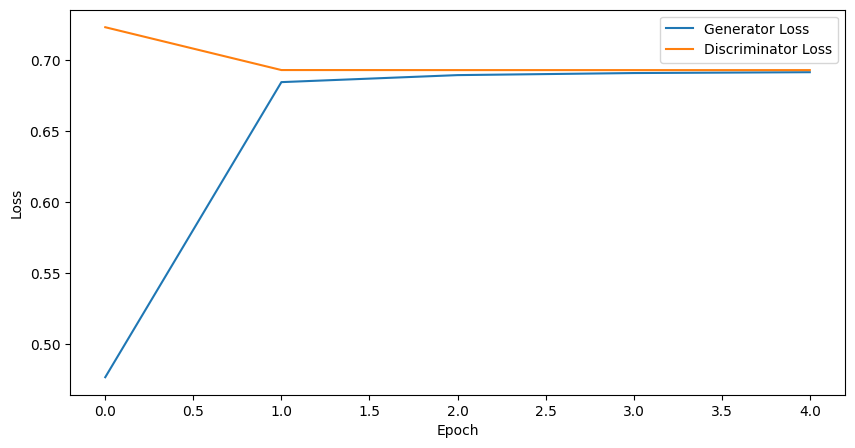

In [28]:
num_epochs  = 500
mean_generator_loss = 0
mean_discriminator_loss = 0
dis_lossi = []
gen_lossi = []
for epoch in range(num_epochs):
        x,y = build_dataset(train_X,train_label)
        
        fake = gen(x).detach()
        dis_fake = torch.cat((x[:,:,2].view(-1,30,1).clone(),fake.view(-1,1,1)),dim=1).transpose(-1,-2)
        dis_real = torch.cat((x[:,:,2].view(-1,30,1).clone(),y.view(-1,1,1).clone()),dim=1).transpose(-1,-2)
        disc_opt.zero_grad()
        disc_fake_pred = disc(dis_fake)
        disc_fake_loss = criterion(disc_fake_pred,torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(dis_real)
        disc_real_loss = criterion(disc_real_pred,torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        #disc_loss = -(torch.mean(disc_real_pred) - torch.mean(disc_fake_pred))
        with torch.no_grad():
            if epoch%100==0:
                print("disc loss: ",disc_loss.item())
                dis_lossi.append(disc_loss.item())
        disc_loss.backward(retain_graph=True)
        disc_opt.step()
        #for p in disc.parameters():
        #    p.data.clamp_(-weight_clipping_limit, weight_clipping_limit)

        gen_opt.zero_grad()
        x2,y2 = build_dataset(train_X,train_label)
        fake2 = gen(x2)
        gen_fake = torch.cat((x2[:,:,2].clone().view(-1,30,1),fake2.view(-1,1,1)),dim=1).transpose(-1,-2)
        disc_fake_pred2 = disc(gen_fake)
        gen_loss = criterion(disc_fake_pred2,torch.ones_like(disc_fake_pred2))

        #gen_loss = -torch.mean(disc_fake_pred2)
        with torch.no_grad():
            if epoch%100==0:
                print("gen loss: ",gen_loss.item())
                gen_lossi.append(gen_loss.item())
        gen_loss.backward()
        gen_opt.step()

plt.figure(figsize=(10, 5))
plt.plot(gen_lossi, label='Generator Loss')
plt.plot(dis_lossi, label='Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

(490, 1)
6.7901587
99.97008342854679


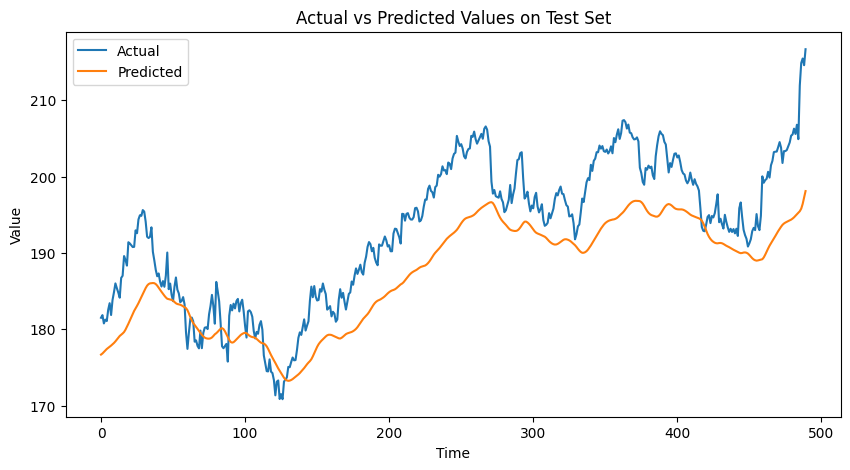

In [44]:
print(test_label.shape)
from sklearn.metrics import mean_absolute_percentage_error
gen.eval()
with torch.no_grad():
    test_predictions = gen(test_X).cpu().numpy()
test_label= np.reshape(test_label,(-1,1))

rescaled_Real_price = y_scaler.inverse_transform(test_label)
rescaled_Predicted_price = y_scaler.inverse_transform(test_predictions)
rmse = np.sqrt(np.mean((rescaled_Predicted_price - rescaled_Real_price) ** 2))
print(rmse)
mape = mean_absolute_percentage_error(rescaled_Real_price,rescaled_Predicted_price)
accuracy = 100 - mape
print(accuracy)
plt.figure(figsize=(10, 5))
plt.plot(rescaled_Real_price, label='Actual')
plt.plot(rescaled_Predicted_price, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values on Test Set')
plt.legend()
plt.show()
